In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.models import Model

from time import time

# Building data

## Equations of motion

In [0]:
k = -1.0
gamma = 0.5
m = 1

n_dims = 1

f = lambda x: -(k*x + gamma*x**3)

SHO_equations = lambda t, X: [X[1]/m, f(X[0])]

## Dataset construction

In [0]:
n_dims = 1
time_step = 0.5

N_train = 10000

X0_train = np.empty([N_train, 2, n_dims], dtype=np.float64)
X1_train = np.empty([N_train, 2, n_dims], dtype=np.float64)

for i in range(N_train):
  sol = solve_ivp(SHO_equations, [0,time_step],
                  np.random.normal(0, 2, 2)).y.transpose()
  X0_train[i] = np.expand_dims(sol[0], axis=-1)
  X1_train[i] = np.expand_dims(sol[-1], axis=-1)

# Model Setup

## Potential Network

In [0]:
def swish(x):
    return tf.sigmoid(x) * x

def swish_layer(units, reg_scale=0.01, weight_scale = 1.0, shape=None):
    k_init = keras.initializers.RandomUniform(minval=-weight_scale,
                                              maxval=weight_scale)
    
    b_init = keras.initializers.RandomUniform(minval=-weight_scale,
                                              maxval=weight_scale)
    
    k_reg = keras.regularizers.l2(reg_scale)
    
    if shape is not None:
        return Dense(units, input_shape=shape,
                     activation=swish, 
                     kernel_regularizer=k_reg,
                     kernel_initializer=k_init,
                     bias_initializer=b_init)
    else:
        return Dense(units,
                     activation=swish, 
                     kernel_regularizer=k_reg,
                     kernel_initializer=k_init,
                     bias_initializer=b_init)

    
def swish_mlp(input_dim, output_dim, layer_sizes,
              reg_scale = 0.01, weight_scale = 1.0):
  
    mlp = keras.models.Sequential()
    mlp.add(swish_layer(layer_sizes[0],
                        reg_scale=reg_scale, weight_scale = weight_scale,
            shape=(input_dim,)))
    
    for layer in layer_sizes[1:]:
        mlp.add(swish_layer(layer,
                reg_scale=reg_scale, weight_scale = weight_scale))
        
    mlp.add(swish_layer(output_dim,
                        reg_scale=reg_scale, weight_scale = weight_scale))
    return mlp

## Solver Network

In [0]:
def hamiltonian_time_evolution(n_dims, potential):
    X = Input(shape=(2,n_dims,))

    Q = Lambda(lambda x: x[:,0])(X)
    P = Lambda(lambda x: x[:,1])(X)

    T = Lambda(lambda p: tf.reduce_sum((1/(2*m))*p**2))(P)
    #V = Lambda(lambda q: tf.reduce_sum((k/2)*q**2 + (gamma/4)*q**4))(Q)
    V = potential(Q)

    gradients = Lambda(lambda x: tf.gradients(x[0],x[1])[0])

    dPdt = Lambda(lambda x: tf.negative(x))(gradients((V,Q)))
    dQdt = gradients((T,P))
    
    dPQdt = Reshape((2,n_dims))(Concatenate(axis=-1)([dQdt,dPdt]))

    return Model(inputs=X, outputs=dPQdt)

def rk4_step(f, n_dims, time_step):
    X0 = Input(shape=(2,n_dims,))

    k1 = f(X0)
    k2 = f(Add()([X0, Lambda(lambda k: (time_step/2)*k)(k1)]))
    k3 = f(Add()([X0, Lambda(lambda k: (time_step/2)*k)(k2)]))
    k4 = f(Add()([X0, Lambda(lambda k: time_step*k)(k3)]))
    
    k5 = Add()([k1,Lambda(lambda k: 2*k)(k2),
                Lambda(lambda k: 2*k)(k3),k4])
    
    X1 = Lambda(lambda k: (time_step/6)*k)(k5)
    
    return Model(inputs=X0, outputs=X1)

def prediction_model(n_dims, f, time_step):
    X0 = keras.layers.Input(shape=(2,n_dims,))
    
    dXdt = hamiltonian_time_evolution(n_dims, f)
    dX = rk4_step(dXdt, n_dims, time_step)

    return Model(inputs=X0, outputs=Add()([X0, dX(X0)]))

## Complete Model

In [0]:
prediction_steps = 1
Fq = swish_mlp(n_dims, 1, [10,20,20,10],
               reg_scale=0.00001, weight_scale = 1.0)

model = prediction_model(n_dims, Fq, time_step)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='mse', metrics=['mse'])

9.21188497543335


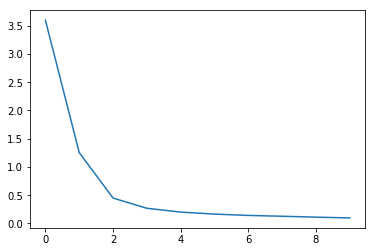

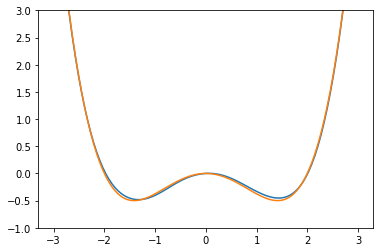

In [0]:
start = time()
result = model.fit(x=X0_train,y=X1_train,
                   batch_size=100, epochs=10, shuffle=True, verbose=0)
print(time()-start)

plt.plot(result.history['loss'])

plt.show()

q = np.linspace(-3,3,100)
q0 = Fq.predict([0])[0,0]
plt.plot(q, Fq.predict(q)[:,0]-q0)
plt.plot(q, (k*q**2)/2+(gamma*q**4)/4)
#plt.plot(q, (k*q)+(gamma*q**3))
plt.ylim([-1,3])
plt.show()

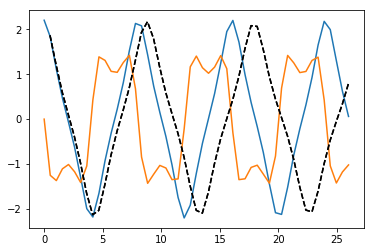

In [0]:
n_points = 50
duration = time_step*n_points+1

xp = [2.2,0]
t = np.linspace(0, duration,n_points+1)
X = solve_ivp(SHO_equations, [0,duration], xp, t_eval=t).y.transpose()

plt.plot(t, X)

prediction = np.empty([n_points,2])

xp = np.reshape(np.array(xp), (1,2,1))
for i in range(n_points):
    xp = model.predict(xp)
    prediction[i] = xp[0,0]
  
plt.plot(np.linspace(time_step, duration, n_points),
         prediction, '--k')